In [979]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import RobustScaler,StandardScaler, MinMaxScaler , LabelEncoder,OneHotEncoder,OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV,cross_validate
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,roc_auc_score, roc_curve,ConfusionMatrixDisplay,silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans , DBSCAN
from itertools import combinations
from sklearn.decomposition import PCA

In [980]:
df = pd.read_csv('sales_data_sample.csv' , encoding='latin1')

In [981]:
df.sample(5)

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
597,10379,39,100.00,2,5399.55,02/10/2005 0:00,Shipped,1,2,2005,...,"C/ Moralzarzal, 86",NaN,Madrid,NaN,28034,Spain,EMEA,Freyre,Diego,Medium
119,10273,30,100.00,4,3508.80,7/21/2004 0:00,Shipped,3,7,2004,...,Rue Joseph-Bens 532,NaN,Bruxelles,NaN,B-1180,Belgium,EMEA,Dewey,Catherine,Medium
1163,10378,43,96.49,10,4149.07,02/10/2005 0:00,Shipped,1,2,2005,...,"C/ Moralzarzal, 86",NaN,Madrid,NaN,28034,Spain,EMEA,Freyre,Diego,Medium
1680,10264,37,65.10,6,2408.70,6/30/2004 0:00,Shipped,2,6,2004,...,8616 Spinnaker Dr.,NaN,Boston,MA,51003,USA,NaN,Yoshido,Juri,Small
1901,10186,21,69.04,3,1449.84,11/14/2003 0:00,Shipped,4,11,2003,...,120 Hanover Sq.,NaN,London,NaN,WA1 1DP,UK,EMEA,Hardy,Thomas,Small


In [982]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ORDERNUMBER       2823 non-null   int64  
 1   QUANTITYORDERED   2823 non-null   int64  
 2   PRICEEACH         2823 non-null   float64
 3   ORDERLINENUMBER   2823 non-null   int64  
 4   SALES             2823 non-null   float64
 5   ORDERDATE         2823 non-null   object 
 6   STATUS            2823 non-null   object 
 7   QTR_ID            2823 non-null   int64  
 8   MONTH_ID          2823 non-null   int64  
 9   YEAR_ID           2823 non-null   int64  
 10  PRODUCTLINE       2823 non-null   object 
 11  MSRP              2823 non-null   int64  
 12  PRODUCTCODE       2823 non-null   object 
 13  CUSTOMERNAME      2823 non-null   object 
 14  PHONE             2823 non-null   object 
 15  ADDRESSLINE1      2823 non-null   object 
 16  ADDRESSLINE2      302 non-null    object 


In [983]:
df.shape

(2823, 25)

In [984]:
num = df.select_dtypes(exclude='object')
cat = df.select_dtypes(include='object')

In [985]:
num.describe()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,QTR_ID,MONTH_ID,YEAR_ID,MSRP
count,2823.000000,2823.000000,2823.000000,2823.000000,2823.000000,2823.000000,2823.000000,2823.00000,2823.000000
mean,10258.725115,35.092809,83.658544,6.466171,3553.889072,2.717676,7.092455,2003.81509,100.715551
std,92.085478,9.741443,20.174277,4.225841,1841.865106,1.203878,3.656633,0.69967,40.187912
min,10100.000000,6.000000,26.880000,1.000000,482.130000,1.000000,1.000000,2003.00000,33.000000
25%,10180.000000,27.000000,68.860000,3.000000,2203.430000,2.000000,4.000000,2003.00000,68.000000
50%,10262.000000,35.000000,95.700000,6.000000,3184.800000,3.000000,8.000000,2004.00000,99.000000
75%,10333.500000,43.000000,100.000000,9.000000,4508.000000,4.000000,11.000000,2004.00000,124.000000
max,10425.000000,97.000000,100.000000,18.000000,14082.800000,4.000000,12.000000,2005.00000,214.000000


In [986]:
cat.describe()

,ORDERDATE,STATUS,PRODUCTLINE,PRODUCTCODE,CUSTOMERNAME,PHONE,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
count,2823,2823,2823,2823,2823,2823,2823,302,2823,1337,2747,2823,1749,2823,2823,2823
unique,252,6,7,109,92,91,92,9,73,16,73,19,3,77,72,3
top,11/14/2003 0:00,Shipped,Classic Cars,S18_3232,Euro Shopping Channel,(91) 555 94 44,"C/ Moralzarzal, 86",Level 3,Madrid,CA,28034,USA,EMEA,Freyre,Diego,Medium
freq,38,2617,967,52,259,259,259,55,304,416,259,1004,1407,259,259,1384


In [987]:
num.isnull().sum().sort_values(ascending=False)

ORDERNUMBER        0
QUANTITYORDERED    0
PRICEEACH          0
ORDERLINENUMBER    0
SALES              0
QTR_ID             0
MONTH_ID           0
YEAR_ID            0
MSRP               0
dtype: int64

In [988]:
cat.isnull().sum().sort_values(ascending=False)

ADDRESSLINE2        2521
STATE               1486
TERRITORY           1074
POSTALCODE            76
PRODUCTCODE            0
ORDERDATE              0
PRODUCTLINE            0
STATUS                 0
ADDRESSLINE1           0
PHONE                  0
CUSTOMERNAME           0
CITY                   0
COUNTRY                0
CONTACTLASTNAME        0
CONTACTFIRSTNAME       0
DEALSIZE               0
dtype: int64

In [989]:
df.drop(columns=['ADDRESSLINE2' , 'STATE' , 'TERRITORY'] , inplace=True)

In [990]:
df['POSTALCODE'].fillna(df['POSTALCODE'].mode()[0],inplace=True)

C:\Users\bisho\AppData\Local\Temp\ipykernel_17324\798346177.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['POSTALCODE'].fillna(df['POSTALCODE'].mode()[0],inplace=True)


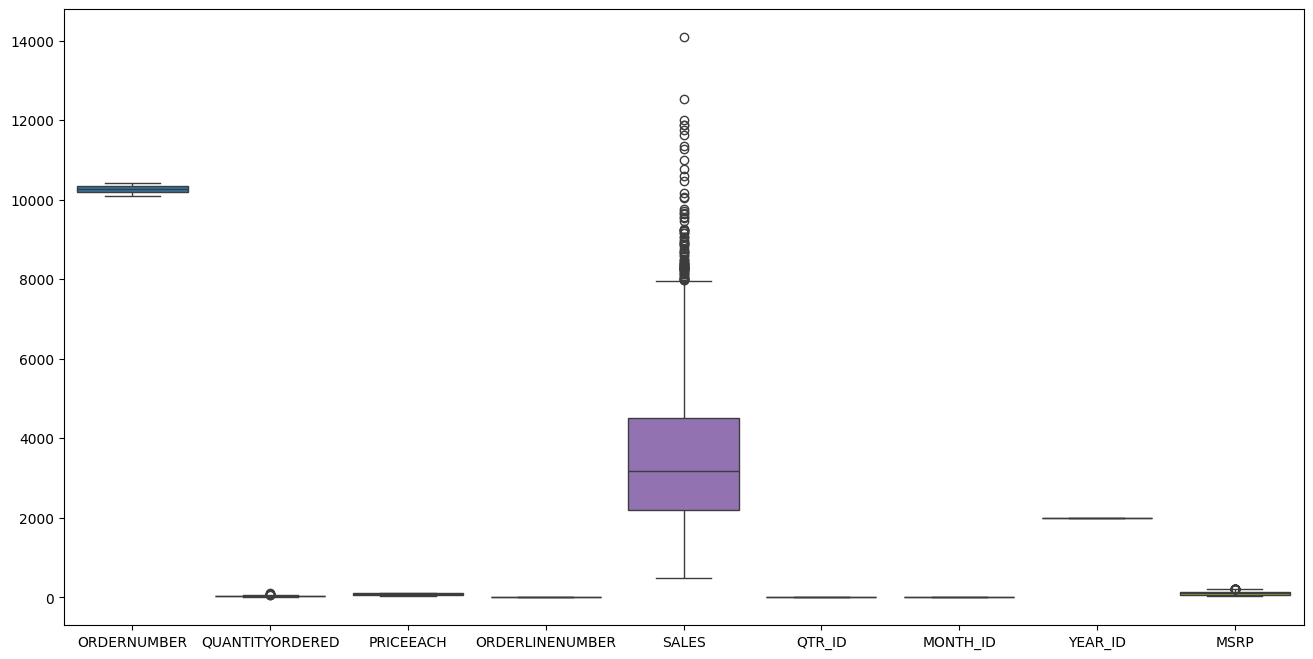

In [991]:
plt.figure(figsize=(16,8))
sns.boxplot(num)
plt.show()

<Axes: xlabel='SALES', ylabel='Density'>

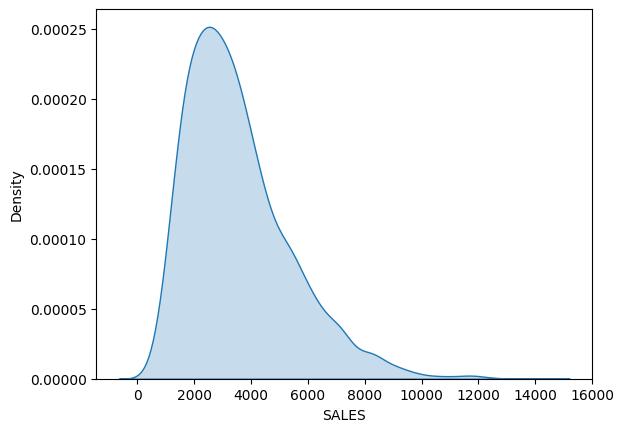

In [992]:
sns.kdeplot(df['SALES'] , fill=True)

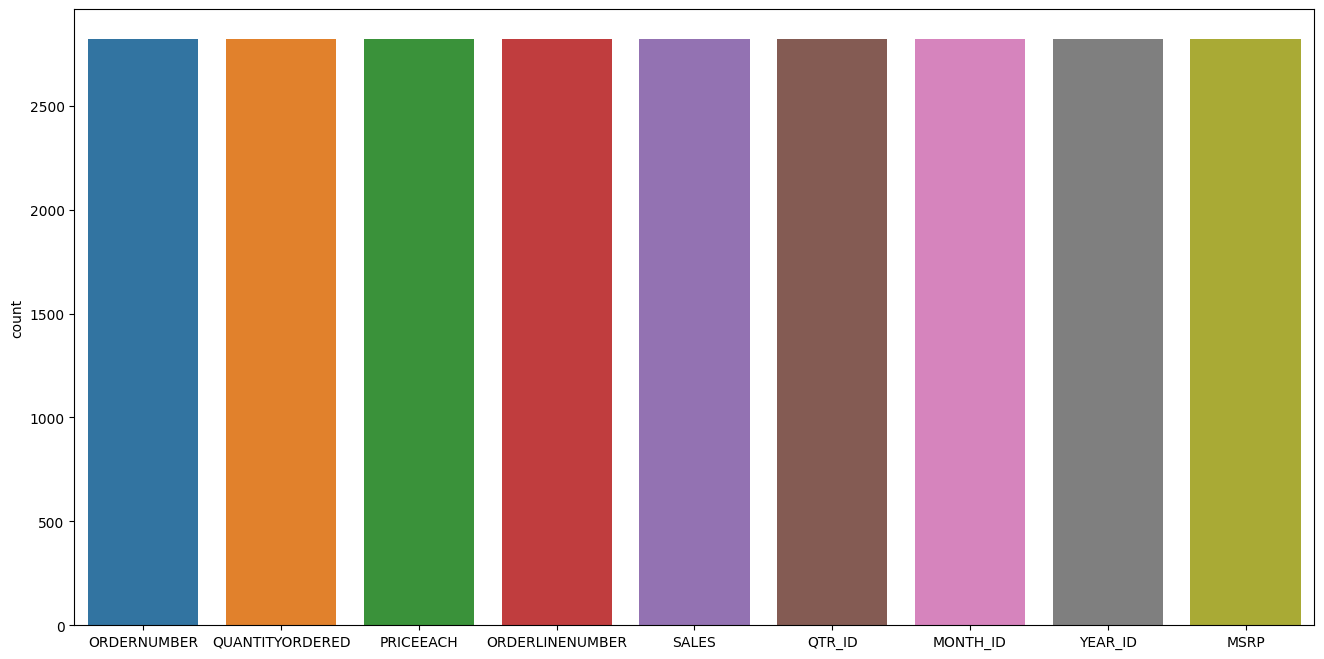

In [993]:
plt.figure(figsize=(16,8))
sns.countplot(num)
plt.show()

In [994]:
# num.drop(columns=['ORDERNUMBER' , 'QTR_ID' , 'MONTH_ID' , 'YEAR_ID' , 'ORDERLINENUMBER'] , inplace=True)
num.drop(columns=['ORDERNUMBER'] , inplace=True)

In [995]:
for col in num:
    print(col , ":" , num[col].unique())

QUANTITYORDERED : [30 34 41 45 49 36 29 48 22 37 23 28 46 42 20 21 24 66 26 38 47 35 32 40
 50 39 27 44 31 33 43 56 25 64 19 12 55 10 54 97 61 51 59 76  6 15 60 65
 58 16 70 13 18 52 11 62 85 77]
PRICEEACH : [95.7  81.35 94.74 ... 55.69 97.16 62.24]
ORDERLINENUMBER : [ 2  5  6 14  1  9  7 13 12  4 11  8  3 10 17 16 15 18]
SALES : [2871.   2765.9  3884.34 ... 3978.51 5417.57 2116.16]
QTR_ID : [1 2 3 4]
MONTH_ID : [ 2  5  7  8 10 11 12  1  4  6  9  3]
YEAR_ID : [2003 2004 2005]
MSRP : [ 95 214 118 193 136 147 194 207 150 151 117 173  79 115 116 141 102  53
 124 157 170  77 142 163  60 122 127  84 168 132 101  62  86 104 169 100
  80  99 146 105 143  92  87 121  50 148  71  73  57 112 109  33  76  44
  69  90  35  68  37  88  85  61  65 107  83 140  41  97  72  96  40  54
  64  43  58  81  66  91  74  49]


In [996]:
num.var().sort_values(ascending=False)

SALES              3.392467e+06
MSRP               1.615068e+03
PRICEEACH          4.070014e+02
QUANTITYORDERED    9.489571e+01
ORDERLINENUMBER    1.785773e+01
MONTH_ID           1.337097e+01
QTR_ID             1.449322e+00
YEAR_ID            4.895383e-01
dtype: float64

In [997]:
from sklearn.preprocessing import OneHotEncoder

# one hot encoding للأعمدة الكاتيجوري
ohe = OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore")
cat_encoded = ohe.fit_transform(cat)

# نحول الناتج لـ DataFrame ونرجع الأسماء
import pandas as pd
cat_encoded = pd.DataFrame(cat_encoded, columns=ohe.get_feature_names_out(cat.columns), index=cat.index)


In [998]:
# cat.drop(columns=['COUNTRY' , 'STATE' , 'PRODUCTLINE' , 'ADDRESSLINE2' , 'TERRITORY' , 'STATUS' , 'DEALSIZE'],inplace=True)

In [999]:
# for col in cat:
#     print(col , ":" , cat[col].unique())

In [1000]:
# دمج الكاتيجوري بعد الـ one hot مع النميريكال
df_new = pd.concat([num, cat_encoded], axis=1)

In [1001]:
df_new.shape

(2823, 990)

In [1002]:
df_new.var().sort_values(ascending=False)

SALES                        3.392467e+06
MSRP                         1.615068e+03
PRICEEACH                    4.070014e+02
QUANTITYORDERED              9.489571e+01
ORDERLINENUMBER              1.785773e+01
                                 ...     
ORDERDATE_08/04/2004 0:00    3.542331e-04
ORDERDATE_04/11/2003 0:00    3.542331e-04
ORDERDATE_4/20/2004 0:00     3.542331e-04
ORDERDATE_4/21/2003 0:00     3.542331e-04
ORDERDATE_8/13/2003 0:00     3.542331e-04
Length: 990, dtype: float64

In [1003]:
st = MinMaxScaler()
for col in df_new.columns:
    df_new[col] = st.fit_transform(df_new[[col]])

In [1004]:
# sns.pairplot(df_new)

In [1005]:
pca = PCA(n_components=2)
X_train = pca.fit_transform(df_new)

In [1006]:
X_train = pd.DataFrame(X_train,columns=['x1' , 'x2'])

In [1007]:
score = -1
best_n = -1
for i in range(2,15):
    km = KMeans(n_clusters=i , random_state=42)
    y_pred = km.fit_predict(X_train)
    temp = silhouette_score(X_train,y_pred)
    if temp >= score:
        score = temp
        best_n = i

In [1008]:
(score,best_n)

(np.float64(0.7549188701984426), 3)

In [1009]:
km = KMeans(n_clusters=3,random_state=42)
km.fit(X_train)

KMeans(n_clusters=3, random_state=42)

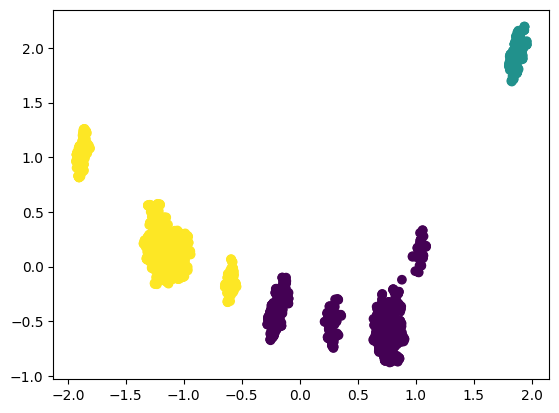

In [1010]:
plt.scatter(X_train['x1'] , X_train['x2'] , c = km.labels_)

In [1011]:
df_new['cluster'] = km.labels_

C:\Users\bisho\AppData\Local\Temp\ipykernel_17324\1280095999.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_new['cluster'] = km.labels_


In [1012]:
df_new

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,QTR_ID,MONTH_ID,YEAR_ID,MSRP,ORDERDATE_01/05/2005 0:00,ORDERDATE_01/06/2003 0:00,...,CONTACTFIRSTNAME_Veysel,CONTACTFIRSTNAME_Victoria,CONTACTFIRSTNAME_Violeta,CONTACTFIRSTNAME_Wendy,CONTACTFIRSTNAME_William,CONTACTFIRSTNAME_Wing C,CONTACTFIRSTNAME_Yoshi,DEALSIZE_Medium,DEALSIZE_Small,cluster
0,0.263736,0.941193,0.058824,0.175644,0.000000,0.090909,0.0,0.342541,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2
1,0.307692,0.744940,0.235294,0.167916,0.333333,0.363636,0.0,0.342541,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
2,0.384615,0.928063,0.058824,0.250150,0.666667,0.545455,0.0,0.342541,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
3,0.428571,0.771061,0.294118,0.240030,0.666667,0.636364,0.0,0.342541,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2
4,0.472527,1.000000,0.764706,0.347273,1.000000,0.818182,0.0,0.342541,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,0.153846,1.000000,0.823529,0.129572,1.000000,1.000000,0.5,0.116022,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
2819,0.252747,1.000000,0.000000,0.257074,0.000000,0.000000,1.0,0.116022,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2820,0.406593,1.000000,0.176471,0.362882,0.000000,0.181818,1.0,0.116022,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
2821,0.307692,0.483589,0.000000,0.120143,0.000000,0.181818,1.0,0.116022,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
